In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

In [2]:
# get the data (doesnt matter what, we are just demonstrating fourier transforms
# will use training data -> largest sample size
df = pd.read_csv("exoData/exoTrain.csv")
df.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


## Fourier Transforms Recap

Much like a Taylor series, which is $\forall f(x)$,
$$
f(x) = \sum_{n=1}^\infty{\frac{(x-a)^n}{n!}\frac{\partial^n f}{\partial x^2}(a)}
$$
A Fourier series is the same idea. Instead of any $f(x)$ being a sum of infinitely many polynomials, it can also be expressed as a sum of infinitely many sine (equivalently, cosine) waves.
$$
f(x) = \frac12 a_0 + \sum_{n=1}^\infty {a_n \cos{nx} + b_n \sin{nx}}
$$

Where

$$
a_m = \frac1\pi \int_{-\pi}^\pi {f(x)\cos{nx}\text{ }dx} $$$$
b_m = \frac1\pi \int_{-\pi}^\pi {f(x)\sin{nx}\text{ }dx}
$$

Though, the complex forms of the FTs are both more useful and easier to remember. They are also how the SciPy 1d Fourier analysis packages are coded (https://docs.scipy.org/doc/scipy/tutorial/fft.html)

The Fourier transform is derived from this idea, and enables us to 'deconstruct' a signal into its components. This is especially usefil when looking at the lightcurves we have.

What we get out of the transforms are the frequencies that present in the light curve, and the amplitudes at which they do. So, a highly persistant, low-frequency orbital period of an exoplanet would show as a tall spike early in the frequency-domain data.

In [3]:
# Plot a lightcurve again, but globally define dictionaries first
# Label dictionary
label_dict = {
    2: "Exoplanet",
    1: "No Exoplanet"
}

# Colour dictionary
c_label = {
    2: "blue",
    1: "red"
}

def plot_lc_idx(df, idx): # Takes the data and the star we want to plot
    flux = df.iloc[idx]
    
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array

    # arbitrary timesteps
    time = np.arange(len(flux))
    
    plt.figure(figsize=(8,6))
    plt.plot(time, flux, linewidth=1, c=c_label[label])
    plt.title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    plt.ylabel("Flux [Apparent Magnitude]")
    plt.xlabel("Time steps")
    plt.tight_layout()
    plt.show()

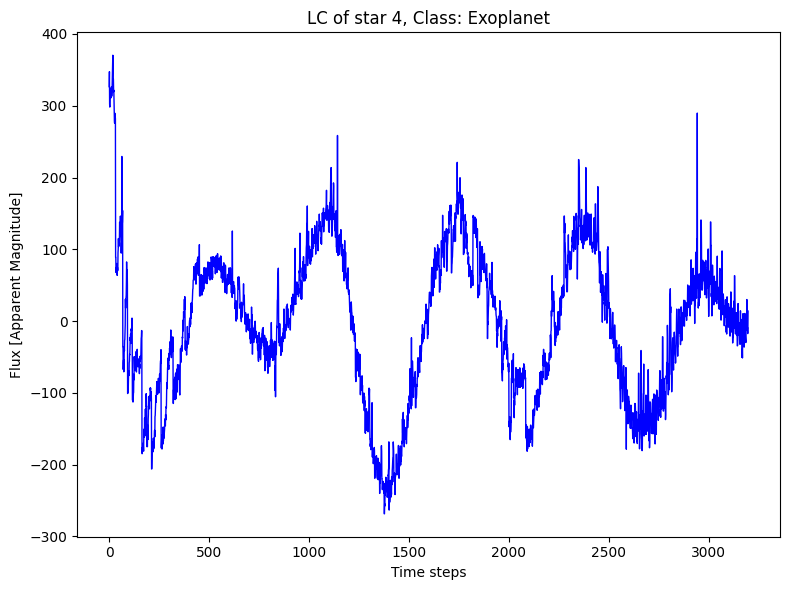

In [4]:
plot_lc_idx(df, 3)

In [16]:
from scipy.fft import rfftfreq, rfft

def plot_fft_lc(df, idx):

    # as before ->
    flux = df.iloc[idx]
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array
    N = len(flux)
    time = np.arange(N) # timesteps

    # preparing for fft
    flux -= np.mean(flux) # <- detrend flux data to FT

    # fft
    freqs = rfftfreq(len(flux), d=np.median(np.diff(time)))
    amps = np.abs(rfft(flux))
    
    # subplots
    f, a = plt.subplots(1, 2, figsize=(16,6))
    a[0].plot(time, flux, linewidth=1, c=c_label[label])
    a[0].set_title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    a[0].set_ylabel("Flux [Apparent Magnitude]")
    a[0].set_xlabel("Time steps")

    a[1].plot(freqs, amps, c="g")
    a[1].set_title("FFT of Light Curve")
    a[1].set_xlabel("Frequency [1/time unit]")
    a[1].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

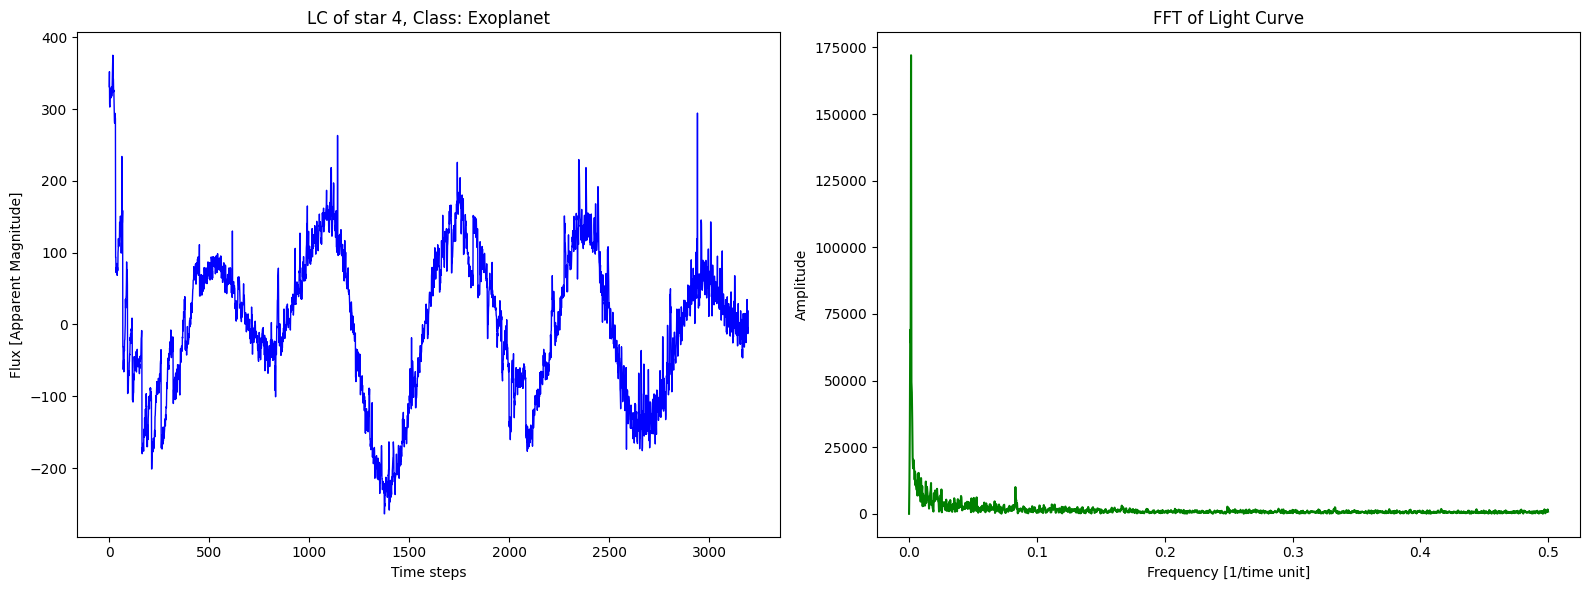

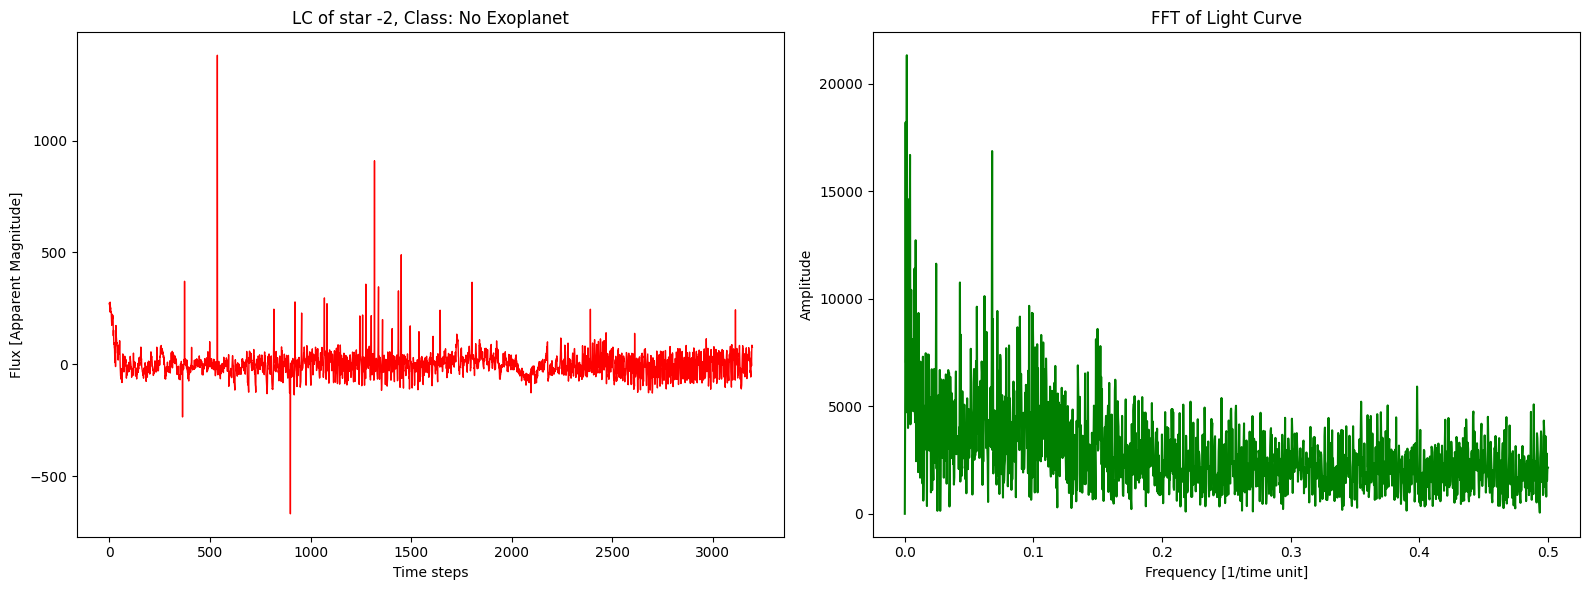

In [17]:
plot_fft_lc(df, 3) # known exoplanet

plot_fft_lc(df, -3) # known non-exoplanet

In [8]:
# We do expect this kind of behavour from the FT graphs of each. 
# An ideal exoplanet would eclipse its stellar host at a regular, observable frequency
# => our favourite star 4 (df.iloc[3] flux readings) shows a light curve that even humans can classify.

# this is cause for some preprocessing.
# 1. de-trend every row
# 2. normalise every row,
# => give each light curve mu=0, sigma=1.

df = pd.read_csv("exoData/exoTrain.csv")

# split into X, y first
X = df.drop(["LABEL"], axis=1)
y = df["LABEL"]

# since sklearn's StandardScaler works by column, we do this manually.
means = X.mean(axis=1)
stdvs = X.std(axis=1)

X = X.sub(means, axis=0).div(stdvs, axis=0)

In [9]:
print(X.shape, y.shape)

(5087, 3197) (5087,)


In [10]:
# ensure that each row meets our criteria
import random

for _ in range(10):
    j = random.randint(0, X.shape[0]-1)
    print(
        f"Testing row {j}\n Mean:", X.iloc[j].mean(), "\n Standard Deviation:", X.iloc[j].std(), "\n"
    )

Testing row 3443
 Mean: 4.2672569679680714e-16 
 Standard Deviation: 1.0 

Testing row 3650
 Mean: -1.155715428824686e-15 
 Standard Deviation: 0.9999999999999999 

Testing row 3530
 Mean: 8.890118683266815e-18 
 Standard Deviation: 1.0 

Testing row 1878
 Mean: 1.0223636485756838e-16 
 Standard Deviation: 1.0 

Testing row 3647
 Mean: 2.0002767037350335e-17 
 Standard Deviation: 1.0 

Testing row 5048
 Mean: -8.667865716185145e-17 
 Standard Deviation: 0.9999999999999998 

Testing row 112
 Mean: 2.6670356049800446e-17 
 Standard Deviation: 1.0 

Testing row 955
 Mean: -5.0006917593375837e-17 
 Standard Deviation: 1.0 

Testing row 993
 Mean: -1.0668142419920179e-16 
 Standard Deviation: 0.9999999999999999 

Testing row 2844
 Mean: -7.112094946613452e-17 
 Standard Deviation: 1.0 



In [13]:
# These mean values are floating point noise, this is perfectly fine. The scaling worked.
# Now, we want to fft the data.

def FT(X):
    return np.abs(rfft(X, axis=1))

X = FT(X)

## Savitzky Golay filter

A type of smoothing filter that fits a low-order polynomial over sequential windows of signal.

In [19]:
from scipy.signal import savgol_filter

def savgol_FT(X, idx): # takes the df, and a star we want to plot everything of.
    # all the following as before ->
    flux = df.iloc[idx]
    label = flux["LABEL"] # isolate labels
    flux = flux.drop(["LABEL"]) # get flux array
    N = len(flux)

    # have the four arrays necessary
    time = np.arange(N) # timesteps
    flux -= np.mean(flux) # <- detrend flux data to FT
    freqs = rfftfreq(len(flux), d=np.median(np.diff(time)))
    amps = np.abs(rfft(flux))

    # savgol
    amps_smooth = savgol_filter(amps, window_length=11, polyorder=3)
    
    # subplots
    f, a = plt.subplots(1, 2, figsize=(16,6))
    a[0].plot(time, flux, linewidth=1, c=c_label[label])
    a[0].set_title(f"LC of star {idx + 1}, Class: {label_dict[label]}")
    a[0].set_ylabel("Flux [Apparent Magnitude]")
    a[0].set_xlabel("Time steps")

    a[1].plot(freqs, amps, c="g")
    a[1].plot(freqs, amps_smooth, c="orange")
    a[1].set_title("FFT of Light Curve w/ Savgol")
    a[1].set_xlabel("Frequency [1/time unit]")
    a[1].set_ylabel("Amplitude")
    
    plt.tight_layout()
    plt.show()

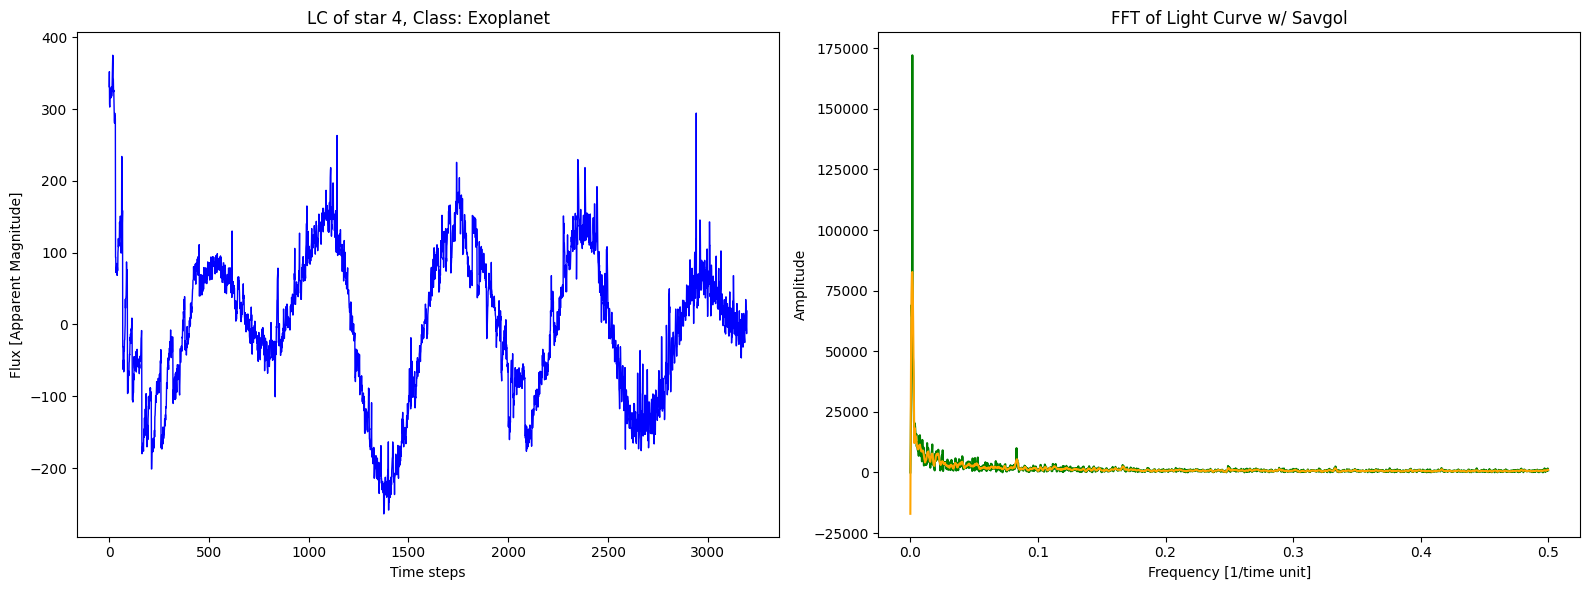

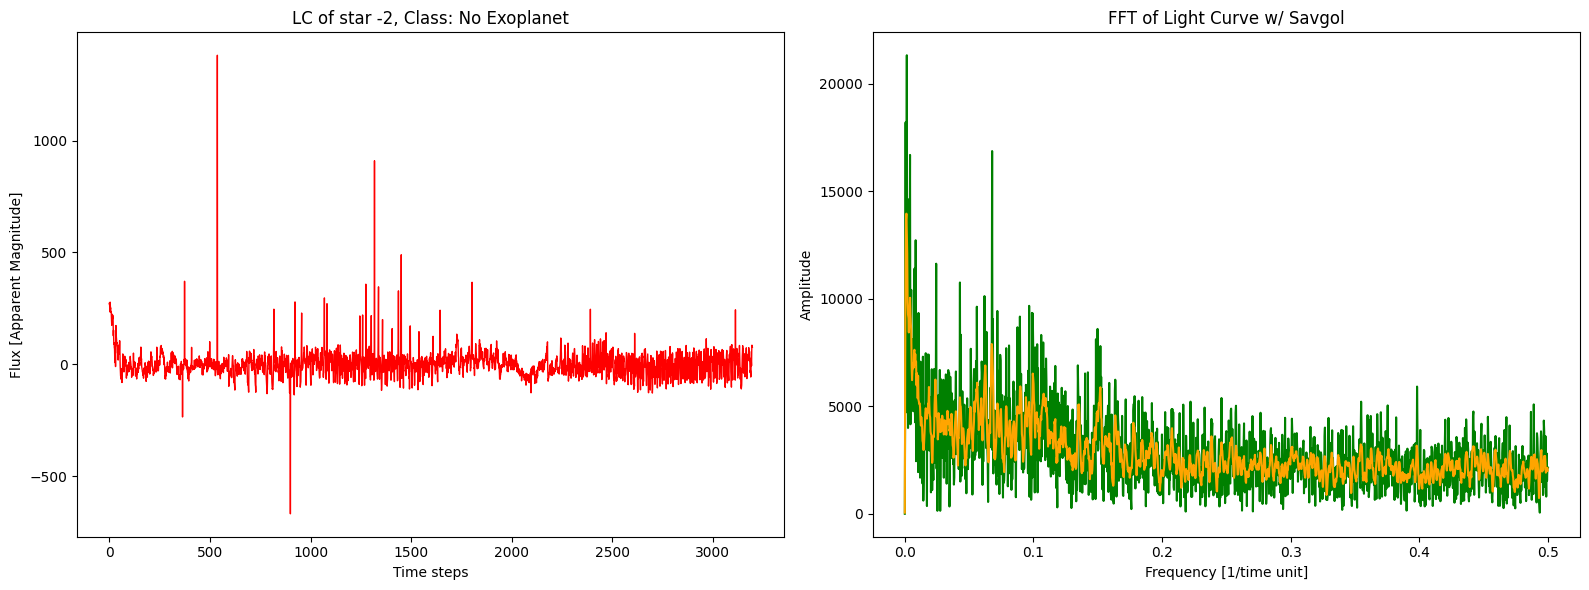

In [22]:
savgol_FT(df.drop(["LABEL"], axis=1), 3)
savgol_FT(df.drop(["LABEL"], axis=1), -3)

In [23]:
# lets write a preprocessing pipeline, so that we can take the raw data and extract a filtered FT light curve:

# start from the beginning, and split the classes from the features
df = pd.read_csv("exoData/exoTrain.csv")
X = df.drop(["LABEL"], axis=1)
y = df["LABEL"]

def preprocess(X): # light curves (rows) - no label column

    # 1. zero-mean, unit-variance scaling (compacted onto a single line, less variables => less memory)
    X = X.sub(X.mean(axis=1), axis=0).div(X.std(axis=1), axis=0)

    # 2. Fourier transform the lightcurves
    X = np.abs(rfft(X, axis=1))

    # 3. Savitzky Golay smoothing
    X = savgol_filter(X, window_length=13, polyorder=3, axis=1)

    return X # <- ML-ready frequency-domain data

X = preprocess(X)

In [26]:
# run a typical MLP architecture onto the preprocessed data
# i am going to try this, i found it on another project on this dataset:
# -> 1 hidden layer w/ 40 neurons
# -> 1 output layer w/ 2 neurons (2 classes of course)
# -> ReLU for hidden layer, sigmoid for output layer
# -> Adam optimiser
# -> dropout = 0.5
# -> L2 regulariser
# -> lr = 0.001
# -> EarlyStopping

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 40),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(40, 2),
            nn.Sigmoid()  # Sigmoid on output layer (2 neurons) implies multilabel
        )

    def forward(self, x):
        return self.net(x)